In [26]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [28]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [29]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [30]:
len(dataset)

68

In [31]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0]


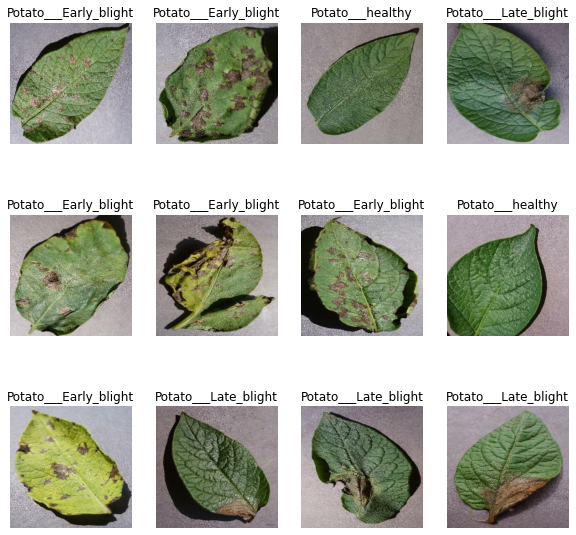

In [32]:
figure = plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        axes = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch.numpy()[i]])
        plt.axis('off')


In [33]:
#80% train 10%test 10% validation
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [34]:
train_ds = dataset.take(54)

In [35]:
test_ds = dataset.skip(54)

In [36]:
len(train_ds),len(test_ds)

(54, 14)

In [37]:
valid_ds = test_ds.take(7)

In [38]:
test_ds = test_ds.skip(7)

In [39]:
len(train_ds),len(valid_ds),len(test_ds)

(54, 7, 7)

In [40]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [41]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [43]:
train_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [44]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [45]:
data_aumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [46]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
with tf.device('/GPU:1'):
    model = models.Sequential([
        resize_and_rescale,
        data_aumentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPool2D((2,2)),
        layers.Flatten(),
        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='sigmoid')
    ])
    
    model.build(input_shape = input_shape)

In [47]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [48]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [49]:
with tf.device('/GPU:1'):
    history = model.fit(
        train_ds,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=val_ds
    )

Epoch 1/50
8/8 [==============================] - 7s 362ms/step - loss: 1.0169 - accuracy: 0.4258 - val_loss: 0.9324 - val_accuracy: 0.4583
Epoch 2/50
8/8 [==============================] - 2s 220ms/step - loss: 0.9176 - accuracy: 0.4922 - val_loss: 0.9237 - val_accuracy: 0.4740
Epoch 3/50
8/8 [==============================] - 2s 202ms/step - loss: 0.9102 - accuracy: 0.4297 - val_loss: 0.9201 - val_accuracy: 0.5781
Epoch 4/50
8/8 [==============================] - 2s 218ms/step - loss: 0.8920 - accuracy: 0.5078 - val_loss: 0.9161 - val_accuracy: 0.4844
Epoch 5/50
8/8 [==============================] - 2s 205ms/step - loss: 0.8660 - accuracy: 0.5430 - val_loss: 0.8823 - val_accuracy: 0.6823
Epoch 6/50
8/8 [==============================] - 2s 198ms/step - loss: 0.8319 - accuracy: 0.6484 - val_loss: 0.8012 - val_accuracy: 0.7344
Epoch 7/50
8/8 [==============================] - 2s 208ms/step - loss: 0.7459 - accuracy: 0.6992 - val_loss: 0.7822 - val_accuracy: 0.7083
Epoch 8/50
8/8 [====

Epoch 42/50
8/8 [==============================] - 2s 206ms/step - loss: 0.0606 - accuracy: 0.9883 - val_loss: 0.2353 - val_accuracy: 0.9062
Epoch 43/50
8/8 [==============================] - 2s 203ms/step - loss: 0.0638 - accuracy: 0.9648 - val_loss: 0.2551 - val_accuracy: 0.8906
Epoch 44/50
8/8 [==============================] - 2s 203ms/step - loss: 0.0818 - accuracy: 0.9531 - val_loss: 0.1882 - val_accuracy: 0.9323
Epoch 45/50
8/8 [==============================] - 2s 202ms/step - loss: 0.0591 - accuracy: 0.9805 - val_loss: 0.2806 - val_accuracy: 0.9115
Epoch 46/50
8/8 [==============================] - 2s 208ms/step - loss: 0.0592 - accuracy: 0.9883 - val_loss: 0.2378 - val_accuracy: 0.9062
Epoch 47/50
8/8 [==============================] - 2s 214ms/step - loss: 0.0570 - accuracy: 0.9727 - val_loss: 0.7005 - val_accuracy: 0.7917
Epoch 48/50
8/8 [==============================] - 2s 211ms/step - loss: 0.1494 - accuracy: 0.9375 - val_loss: 0.5798 - val_accuracy: 0.8281
Epoch 49/50
8

In [50]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 1s 35ms/step - loss: 0.3161 - accuracy: 0.8789


In [51]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 8}

In [52]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

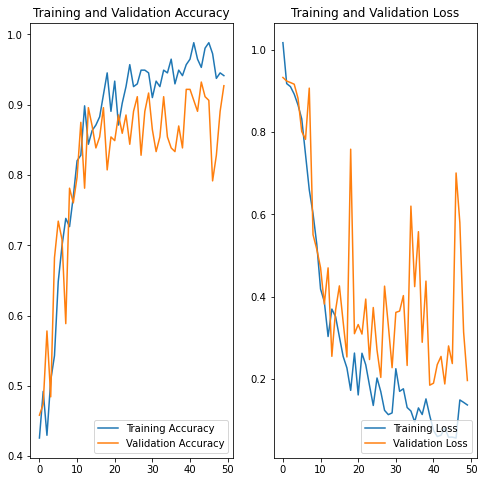

In [54]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

Image to be predicted
Actual class: Potato___healthy
1/1 [==============================] - 0s 187ms/step
Predicted class: Potato___healthy


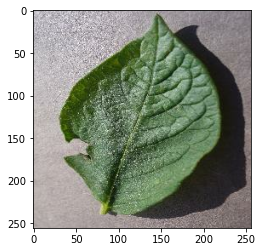

In [55]:
for images_batch, images_label in test_ds.take(1):
    
    first_img = images_batch[0].numpy().astype('uint8')
    first_label = class_names[images_label[0].numpy()]
    
    print('Image to be predicted')
    plt.imshow(first_img)
    print('Actual class: ' + first_label)
    batch_prediction = model.predict(images_batch)
    print('Predicted class: '+class_names[np.argmax(batch_prediction[0])])
    

In [56]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    prediction_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    
    return prediction_class, confidence

1/1 [==============================] - 0s 30ms/step


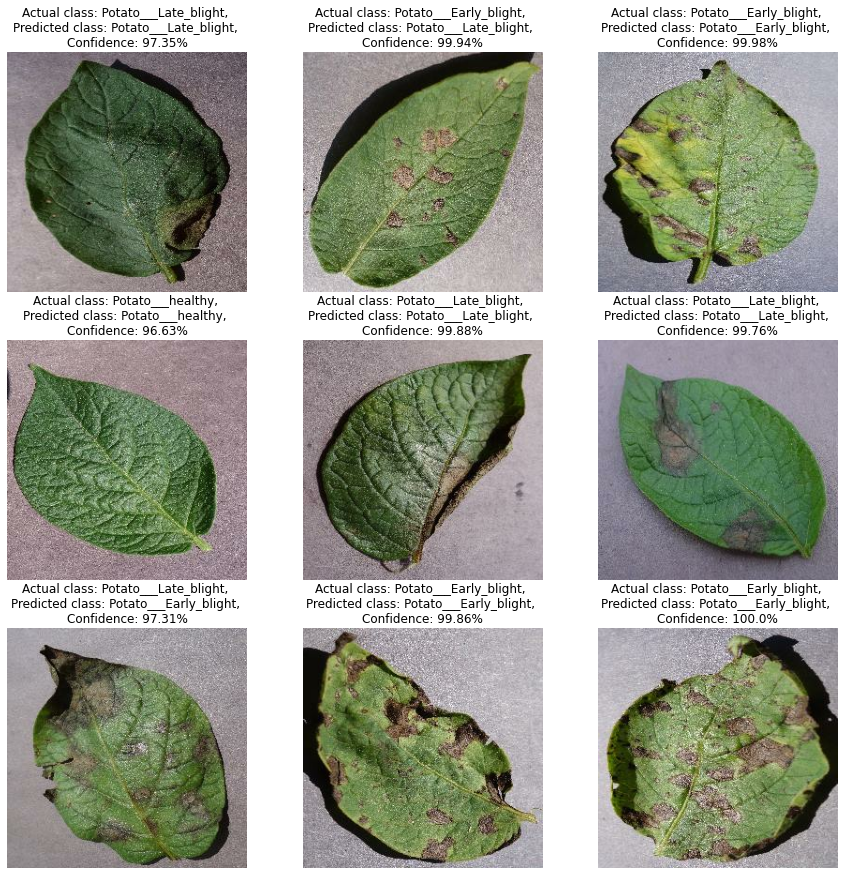

In [57]:
plt.figure(figsize=(15,15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.axis('off')
        prediction_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i].numpy()]
        plt.title(f"Actual class: {actual_class}, \nPredicted class: {prediction_class}, \nConfidence: {confidence}%")
        

In [58]:
model_version = 2
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [63]:
import os
new_version = max([int(i) for i in os.listdir('../models')])+1
model.save(f'../models/{new_version}')

3